In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output


In [17]:
def uniform(batchsz):
    return torch.rand(batchsz,1)

def normal(batchsz):
    return torch.randn(batchsz,1,) + 3


In [18]:


def exponential(batchsz, rate=1.0):
    # Generate normal random samples
    normal_samples = torch.rand(batchsz, 1)
    # Convert to exponential samples
    exponential_samples = -torch.log(normal_samples) / rate
    return exponential_samples


def beta(batchsz, alpha=1.0, beta_param=1.0):
    # Create a Beta distribution object
    beta_dist = torch.distributions.Beta(alpha, beta_param)
    # Generate samples
    beta_samples = beta_dist.sample((batchsz, 1))
    return beta_samples


In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(nn.Linear(1,16),
                                  nn.LeakyReLU(),
                                  nn.Linear(16,1))

    def forward(self,x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(nn.Linear(1,16),
                                  nn.LeakyReLU(),
                                  nn.Linear(16,1),
                                  nn.Sigmoid())

    def forward(self,x):
        return self.model(x)

generator = Generator()
discriminator = Discriminator()

In [12]:
lr = 3e-3
batch_size = 64

In [13]:
gen_optm = torch.optim.Adam(generator.parameters(),lr)
disc_optm = torch.optim.Adam(discriminator.parameters(),lr)

In [14]:

def update_generator(batch_size):
    noise = normal(batch_size)
    out = generator(noise)
    prob_fake_is_real = discriminator(out)
    loss = (- torch.log(prob_fake_is_real)).mean()

    gen_optm.zero_grad()
    loss.backward()
    gen_optm.step()
    return loss.data.numpy().item()
    
    

In [15]:
def update_discriminator(batch_size):

    # real dis
    real = beta(batch_size)
    prob_real_is_real = discriminator(real)

    # fake dis
    noise = normal(batch_size)
    prob_fake_is_real = discriminator(generator(noise))
    prob_fake_is_fake = 1 - prob_fake_is_real

    loss = (- torch.log(prob_real_is_real) - torch.log(prob_fake_is_fake)).mean()

    disc_optm.zero_grad()
    loss.backward()
    disc_optm.step()
    return loss.data.numpy().item()
    
    

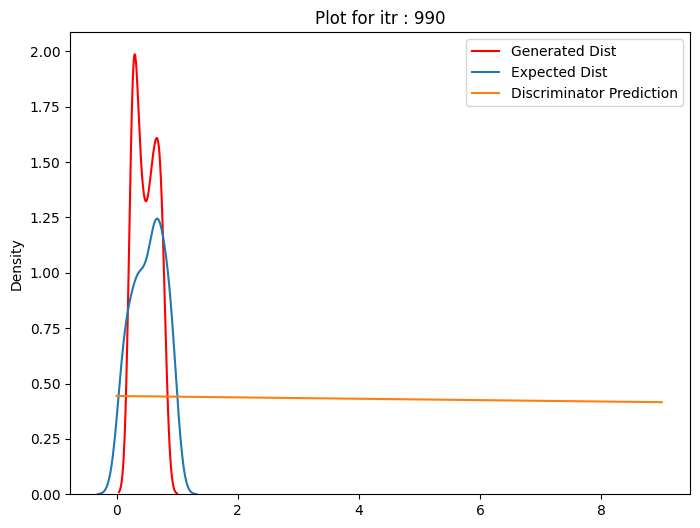

In [16]:
disc_iter = 10
for i in range(1000):
    for _ in range(disc_iter):
        update_discriminator(batch_size)
    update_generator(batch_size)

    if not i % 10:
        clear_output(True)
        plt.figure(figsize=(8,6))

        sns.kdeplot(generator(normal(100)).data.numpy()[:,0], label="Generated Dist",color='red')
        sns.kdeplot(beta(100).data.numpy()[:,0], label="Expected Dist")

        plt.plot(discriminator(torch.linspace(3,8,10).view(10,-1)).data.numpy()[:,0],label="Discriminator Prediction")
        
        plt.legend()
        plt.title(f'Plot for itr : {i}')
        plt.show()